## **Import Necessary Functions**

In [0]:
from pyspark.sql.functions import col, count, upper, concat, lit, when, split, size, concat_ws, lag, monotonically_increasing_id
from pyspark.sql import functions as F
from pyspark.sql import Window

## **Load and Clean Data**

In [0]:
teams = spark.read.csv("21.22_teamdata.csv", header=True, inferSchema=True)

teams = teams.withColumn("TEAM_ABBRV", upper(teams["TEAM_ABBRV"]))

teams_abbrv = teams.select("TEAM", "TEAM_ABBRV")

teams_join = teams.select("TEAM_ABBRV", "oPPG", "dEFF")

teams_join = teams_join.withColumnRenamed("TEAM_ABBRV", "TEAM_DEF")

In [0]:
players_original = spark.read.csv("21.22_playerdata.csv", header=True, inferSchema=True)

players = players_original.withColumn("Team", upper(players_original["TEAM"]))

players = players.dropna()

players_filtered = players.filter(players["GP"] >= 50)

players_new = players.withColumn("GP_Filter", when(players.GP >= 50, "Yes").otherwise("No"))

players_norm = players_new.withColumn("ppg_norm", col("ppg") / col("MPG"))

players_norm = players_norm.withColumn("key", concat(col("FULL NAME"), lit("_"), col("Team")))

players_join = players_norm.select("FULL NAME", "TEAM", "POS", "GP", "MPG", "PPG", "TS%", "eFG%", "2P%", "3P%", "ORTG", "GP_Filter", "key")

In [0]:
shots = spark.read.csv("21.22_shotsdata.csv", header=True, inferSchema=True)

# Split the column by space
split_col = split(col("TEAM_NAME"), " ")

# Determine where to split based on word count
shots_split = shots.withColumn(
    "TEAM_NEW",
    when(size(split_col) == 3, concat_ws(" ", split_col[0], split_col[1]))  # First two words if three exist
    .otherwise(split_col[0])  # First word otherwise
).withColumn(
    "TEAM_NEW2",
    when(size(split_col) == 3, split_col[2])  # Last word if three exist
    .otherwise(split_col[1])  # Second word otherwise
)

shots_renamed = shots_split.withColumn(
    "TEAM",
    when((col("TEAM_NEW") == "Los Angeles") & (col("TEAM_NEW2") == "Lakers"), "LA Lakers")
    .when((col("TEAM_NEW") == "Los Angeles") & (col("TEAM_NEW2") == "Clippers"), "LA Clippers")
    .when((col("TEAM_NEW") == "Portland Trail") & (col("TEAM_NEW2") == "Blazers"), "Portland")
    .otherwise(col("TEAM_NEW"))
)

shots_renamed = shots_renamed.withColumn(
    "AWAY_TEAM",
    when(col("AWAY_TEAM") == "BKN", "BRO").otherwise(col("AWAY_TEAM"))
)
shots_with_abbrv = shots_renamed.join(teams_abbrv, on="TEAM", how="left")

shot_defend = shots_with_abbrv.withColumn(
    "TEAM_DEF",
    when(col("TEAM_ABBRV") == col("HOME_TEAM"), col("AWAY_TEAM")).otherwise(col("HOME_TEAM"))
)

shot_cat = shot_defend.withColumn("SHOT_CAT", when(col("SHOT_MADE") == "true", 1).otherwise(0))

shots_final = shot_cat.withColumn("key", concat(col("PLAYER_NAME"), lit("_"), col("TEAM_ABBRV")))

In [0]:
master_df1 = shots_final.join(players_join, on="key", how="left")
final_master = master_df1.join(teams_join, on="TEAM_DEF", how="left")

In [0]:
final_master = final_master.orderBy(
    col("game_id").asc(),
    col("quarter").asc(),
    col("mins_left").desc(),
    col("secs_left").desc()
)

In [0]:
final_master = final_master.withColumn("shot_order", monotonically_increasing_id())

In [0]:
# Define a window partitioned by game_id and player_id, maintaining shot log order
window_spec = Window.partitionBy("game_id").orderBy(
    col("quarter").asc(), col("mins_left").desc(), col("secs_left").desc()
).rowsBetween(Window.unboundedPreceding, Window.currentRow)

# Calculate cumulative shots taken per player per game
final_master_new = final_master.withColumn("shots_taken", count("player_id").over(window_spec) - 1)

# Calculate cumulative shots made per player per game (only when shot_made = true)
final_master_new = final_master_new.withColumn(
    "shots_made",
    F.sum(when(col("shot_made") == True, 1).otherwise(0)).over(window_spec) - 1
)

# Ensure the first shot in each game for a player starts with 0
first_shot_window = Window.partitionBy("game_id", "player_id").orderBy(
    col("quarter").asc(), col("mins_left").desc(), col("secs_left").desc()
)

final_master_new = final_master_new.withColumn(
    "shots_taken",
    when(count("player_id").over(first_shot_window) == 1, lit(0)).otherwise(col("shots_taken"))
)

final_master_new = final_master_new.withColumn(
    "shots_made",
    when(count("player_id").over(first_shot_window) == 1, lit(0)).otherwise(col("shots_made"))
)

final_master_new = final_master_new.orderBy(
    col("shot_order").asc())

In [0]:
final_master_filter = final_master_new.filter(final_master.GP_Filter == "Yes")

In [0]:
final_master.count()

216722

In [0]:
final_master_filter.count()

161557

## **EDA**

In [0]:
print(f"There are {players.count()} players that played in the 2021-22 season. Of those, {players_filtered.count()} played 50+ games that season.")

There are 661 players that played in the 2021-22 season. Of those, 260 played 50+ games that season.


#### **EDA** - _Shots_

In [0]:
from pyspark.sql.functions import col, count, sum, round

shots_made = final_master_filter.groupBy("event_type") \
  .agg(count("*").alias("count")) \
  .orderBy(col("count").desc())

# Compute total count of shots
total_shots = shots_made.agg(sum("count").alias("total")).collect()[0]["total"]

# Add percentage of total column
shots_made = shots_made.withColumn("percentage", round((col("count") / total_shots) * 100, 2))

display(shots_made)

event_type,count,percentage
Missed Shot,86515,53.55
Made Shot,75042,46.45


In [0]:
action_types = shots.groupBy("action_type") \
  .agg(count("*").alias("count")) \
  .orderBy(col("count").desc()) \

display(action_types.limit(10))

action_type,count
Jump Shot,70930
Pullup Jump shot,26249
Driving Layup Shot,18944
Step Back Jump shot,10310
Driving Floating Jump Shot,9586
Layup Shot,7977
Cutting Layup Shot,5282
Running Layup Shot,5152
Driving Finger Roll Layup Shot,5048
Floating Jump shot,4836


In [0]:
zones = shots.groupBy("ZONE_NAME") \
  .agg(count("*").alias("count")) \
  .orderBy(col("count").desc()) \

display(zones)

ZONE_NAME,count
Center,120736
Left Side Center,28896
Right Side Center,27163
Left Side,20268
Right Side,19184
Back Court,475


In [0]:
basic_zones = shots.groupBy("BASIC_ZONE") \
  .agg(count("*").alias("count")) \
  .orderBy(col("count").desc()) \

display(basic_zones)

BASIC_ZONE,count
Above the Break 3,64447
Restricted Area,62987
In The Paint (Non-RA),39668
Mid-Range,27712
Left Corner 3,11377
Right Corner 3,10091
Backcourt,440


In [0]:
shot_range = shots.groupBy("ZONE_RANGE") \
  .agg(count("*").alias("count")) \
  .orderBy(col("count").desc()) \

display(shot_range)

ZONE_RANGE,count
Less Than 8 ft.,86338
24+ ft.,85880
8-16 ft.,28560
16-24 ft.,15469
Back Court Shot,475


In [0]:
shots_per_quarter = shots.groupBy("QUARTER") \
  .agg(count("*").alias("count")) \
  .orderBy(col("count").desc()) \

display(shots_per_quarter)

QUARTER,count
1,56132
2,54489
3,53475
4,51488
5,985
6,123
7,30


####**EDA** - _Teams_

In [0]:
top_10_shot_teams = shots.groupBy("TEAM_NAME") \
  .agg(count("*").alias("count")) \
  .orderBy(col("count").desc()) \

display(top_10_shot_teams.limit(10))

TEAM_NAME,count
Memphis Grizzlies,7739
San Antonio Spurs,7601
Charlotte Hornets,7497
Toronto Raptors,7489
Minnesota Timberwolves,7458
Phoenix Suns,7389
Indiana Pacers,7338
Milwaukee Bucks,7331
Oklahoma City Thunder,7310
Los Angeles Lakers,7279


In [0]:
bottom_10_shot_teams = shots.groupBy("TEAM_NAME") \
  .agg(count("*").alias("count")) \
  .orderBy(col("count").asc()) \
  
display(bottom_10_shot_teams.limit(10))

TEAM_NAME,count
Philadelphia 76ers,6932
Cleveland Cavaliers,6940
Miami Heat,6954
Dallas Mavericks,6982
Washington Wizards,7056
Utah Jazz,7067
New York Knicks,7069
Denver Nuggets,7079
Houston Rockets,7083
Golden State Warriors,7087


In [0]:
oPPg = teams.select("TEAM", "oPPG")
top10_oPPg = oPPg.orderBy(col("oPPG").asc()).limit(10)
display(top10_oPPg)

TEAM,oPPG
Boston,104.5
Dallas,104.7
Golden State,105.5
Miami,105.6
Cleveland,105.7
New York,106.6
Toronto,107.1
Philadelphia,107.3
Phoenix,107.3
Utah,107.6


In [0]:
dEFF = teams.select("TEAM", "dEFF")
top10_dEFF = dEFF.orderBy(col("dEFF").asc()).limit(10)
display(top10_dEFF)

TEAM,dEFF
Golden State,107.0
Boston,107.0
Phoenix,107.4
Memphis,109.0
Miami,109.1
Dallas,109.4
Cleveland,109.7
LA Clippers,110.2
Utah,110.5
Toronto,110.6


In [0]:
bottom10_oPPg = oPPg.orderBy(col("oPPG").desc()).limit(10)
display(bottom10_oPPg)

TEAM,oPPG
Houston,118.2
Sacramento,115.8
Portland,115.1
LA Lakers,115.1
Indiana,114.9
Charlotte,114.9
Minnesota,113.3
San Antonio,113.0
Detroit,112.5
Atlanta,112.4


In [0]:
bottom10_dEFF = dEFF.orderBy(col("dEFF").desc()).limit(10)
display(bottom10_dEFF)

TEAM,dEFF
Portland,116.9
Houston,116.8
Indiana,116.1
Sacramento,115.4
Atlanta,114.9
Washington,114.6
Detroit,113.8
Charlotte,113.8
Chicago,113.6
LA Lakers,113.5


####**EDA** - _Players_

In [0]:
top_10_shot_takers = final_master_filter.groupBy("player_name") \
  .agg(count("*").alias("count")) \
  .orderBy(col("count").desc()) \

display(top_10_shot_takers.limit(10))

player_name,count
Jayson Tatum,1564
Trae Young,1544
DeMar DeRozan,1535
Devin Booker,1421
Luka Doncic,1403
Donovan Mitchell,1376
Joel Embiid,1334
Nikola Jokic,1311
LaMelo Ball,1254
Julius Randle,1246


In [0]:
eFG = players_filtered.select("FULL NAME", "eFG%")
top10_eFG = eFG.orderBy(col("eFG%").desc()).limit(10)
display(top10_eFG)

FULL NAME,eFG%
Mitchell Robinson,0.761
Robert Williams III,0.736
Rudy Gobert,0.713
Daniel Gafford,0.695
Dwight Powell,0.687
Gary Payton II,0.679
Jarrett Allen,0.678
Damian Jones,0.677
Nick Richards,0.667
Hassan Whiteside,0.652


In [0]:
TS = players_filtered.select("FULL NAME", "TS%")
top10_TS = TS.orderBy(col("TS%").desc()).limit(10)
display(top10_TS)

FULL NAME,TS%
Robert Williams III,0.745
Rudy Gobert,0.732
Dwight Powell,0.725
Mitchell Robinson,0.722
Daniel Gafford,0.709
Damian Jones,0.701
Jarrett Allen,0.698
Nick Richards,0.689
Jaxson Hayes,0.679
Gary Payton II,0.679


In [0]:
two_pt = players_filtered.select("FULL NAME", "2P%")
top10_two_pt = two_pt.orderBy(col("2P%").desc()).limit(10)
display(top10_two_pt)

FULL NAME,2P%
Mitchell Robinson,0.761
Gary Payton II,0.754
Robert Williams III,0.738
Rudy Gobert,0.718
Dwight Powell,0.703
Daniel Gafford,0.697
Damian Jones,0.696
Jarrett Allen,0.688
Matisse Thybulle,0.673
Moritz Wagner,0.672


In [0]:
three_pt = players_filtered.select("FULL NAME", "3P%")
top10_three_pt = three_pt.orderBy(col("3P%").desc()).limit(10)
display(top10_three_pt)

FULL NAME,3P%
Jakob Poeltl,1.0
Dwight Howard,0.533
Isaiah Hartenstein,0.467
Luke Kennard,0.449
Desmond Bane,0.436
Tyrese Maxey,0.427
Cameron Johnson,0.425
Doug McDermott,0.422
P.J. Tucker,0.415
Cory Joseph,0.414


In [0]:
ORTG = players_filtered.select("FULL NAME", "ORTG")
top10_ORTG = ORTG.orderBy(col("ORTG").desc()).limit(10)
display(top10_ORTG)

FULL NAME,ORTG
Robert Williams III,149.8
Dwight Powell,144.5
Mitchell Robinson,144.1
Rudy Gobert,138.5
Brandon Clarke,137.4
Daniel Gafford,136.2
Clint Capela,134.0
John Konchar,133.0
Hassan Whiteside,133.0
Jarrett Allen,132.8


## **Correlations**

In [0]:
numerical_cols = ['GP', 'MPG', 'PPG', 'TS%', 'eFG%', '2P%', '3P%', 'ORTG', 'oPPG', 'dEFF']

for col in numerical_cols:
    correlation = final_master_filter.stat.corr("SHOT_CAT", col)
    print(f"Correlation between SHOT_CAT and {col}: {correlation}")

Correlation between SHOT_CAT and GP: 0.004504726555428531
Correlation between SHOT_CAT and MPG: 0.0038904644914066816
Correlation between SHOT_CAT and PPG: 0.012469068120573657
Correlation between SHOT_CAT and TS%: 0.10006585888179964
Correlation between SHOT_CAT and eFG%: 0.1014264830366379
Correlation between SHOT_CAT and 2P%: 0.10155613503737715
Correlation between SHOT_CAT and 3P%: -0.03608595115539505
Correlation between SHOT_CAT and ORTG: 0.09365930175209722
Correlation between SHOT_CAT and oPPG: 0.0005129161040966958
Correlation between SHOT_CAT and dEFF: 0.00014456490563984854


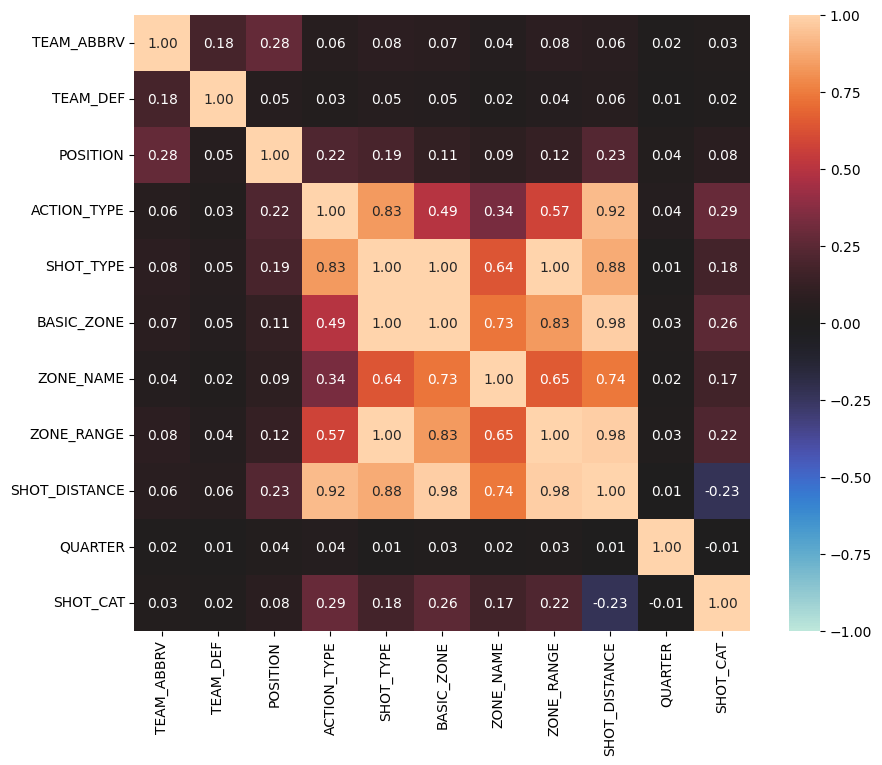

In [0]:
from dython.nominal import associations

master_pandas = final_master_filter.select("TEAM_ABBRV", "TEAM_DEF", "POSITION", "ACTION_TYPE", "SHOT_TYPE", "BASIC_ZONE",
                                           "ZONE_NAME", "ZONE_RANGE", "SHOT_DISTANCE", "QUARTER", "SHOT_CAT").toPandas()

corr_matrix = associations(master_pandas,  figsize=(10, 8))

In [0]:
corrs = corr_matrix['corr'].round(2)
shot_corrs = corrs["SHOT_CAT"]
high_shot_corrs = shot_corrs[shot_corrs > 0.07]
print(high_shot_corrs)

POSITION       0.08
ACTION_TYPE    0.29
SHOT_TYPE      0.18
BASIC_ZONE     0.26
ZONE_NAME      0.17
ZONE_RANGE     0.22
SHOT_CAT       1.00
Name: SHOT_CAT, dtype: float64
